## Load Datasets
Load train and validation splits.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


df_train = pd.read_csv("data/splits/train.csv")
df_val   = pd.read_csv("data/splits/val.csv")
df_test = pd.read_csv("data/splits/test.csv")

print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
print("Test shape:", df_test.shape)

feature_cols = [
    "day_of_month",
    "is_weekend",
    "is_public_holiday",
    "days_from_summer_start",
    "flight_day_of_week",
    "flight_month",
]

target_cols = [c for c in df_train.columns if "days to departure" in c]
target_cols = sorted(target_cols, key=lambda x: int(x.split()[0]))

X_train = df_train[feature_cols].values
X_val   = df_val[feature_cols].values
X_test  = df_test[feature_cols].values

y_train = df_train[target_cols].values
y_val   = df_val[target_cols].values
y_test  = df_test[target_cols].values

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Train shape: (64, 67)
Val shape: (14, 67)
Test shape: (14, 67)
X_train shape: (64, 6)
y_train shape: (64, 60)
X_val shape: (14, 6)
y_val shape: (14, 60)
X_test shape: (14, 6)
y_test shape: (14, 60)


## Train Model
Train a XGBoost regression model to predict flight prices for all 60 days-to-departure horizons.


In [32]:
base_model = XGBRegressor(
    max_depth=100,
    learning_rate=0.001,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model = MultiOutputRegressor(base_model)

print("Training model...")
model.fit(X_train, y_train)
print("Training completed.")

y_val_pred = model.predict(X_val)
print("Prediction completed.")

Training model...
Training completed.
Prediction completed.


## Evaluate and Visualize Results
Calculate MAE metrics and create visualizations comparing predictions to ground truth across different days-to-departures.



PREDICTION COMPARISON SUMMARY - XGBoost

Overall MAE: 67.61
Total predictions: 840
Number of samples: 14
Outputs per sample: 60

First rows:
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  435.381250  550.594727      115.213477
1            0                  2  482.261290  534.129761       51.868470
2            0                  3  529.019355  540.965332       11.945977
3            0                  4  355.332143  543.208313      187.876170
4            0                  5  391.777419  554.581055      162.803635
5            0                  6  505.349643  584.944092       79.594449
6            0                  7  493.862069  568.057983       74.195914
7            0                  8  554.421429  556.037109        1.615681
8            0                  9  504.487097  559.604736       55.117640
9            0                 10  502.997647  565.874756       62.877109
10           0                 11  414.00354

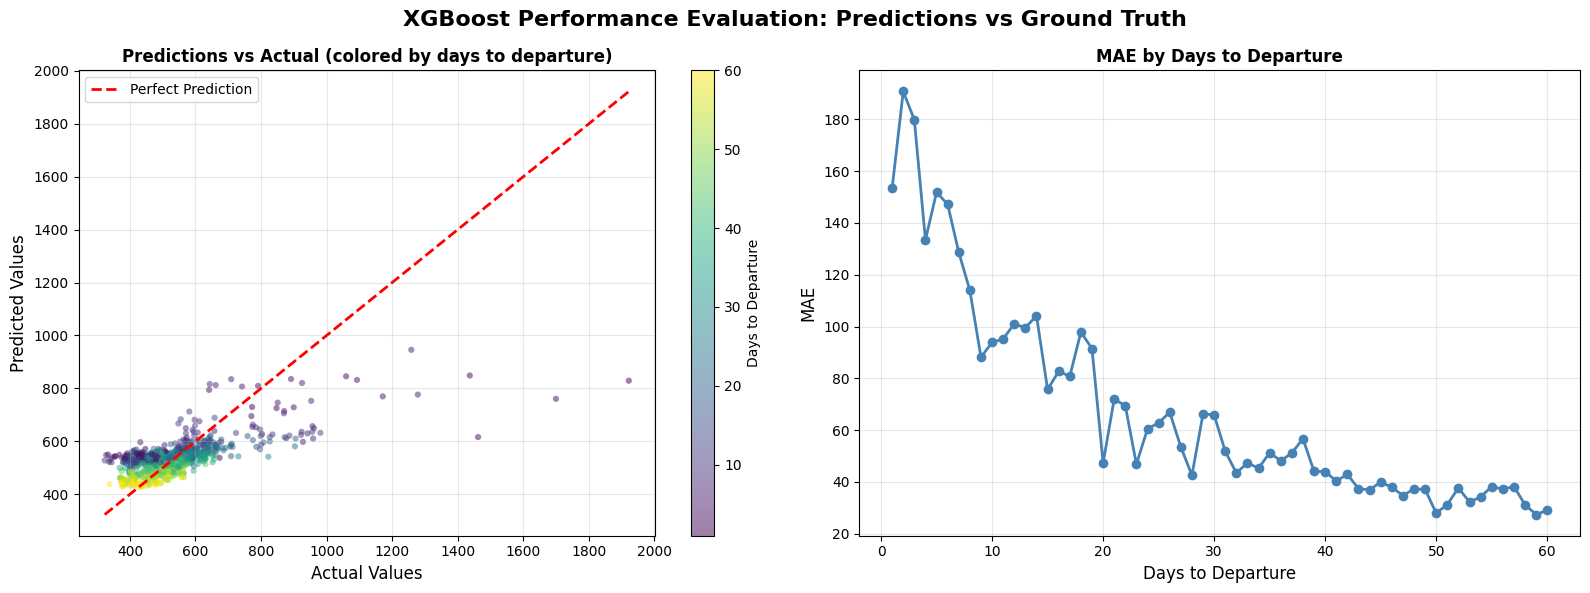

In [16]:
def evaluate_and_visualize_predictions(y_val, y_val_pred, target_cols, model_name="Model"):
    n_samples, n_outputs = y_val.shape
    comparison_data = []

    for sample_idx in range(n_samples):
        for output_idx in range(n_outputs):
            actual = y_val[sample_idx, output_idx]
            predicted = y_val_pred[sample_idx, output_idx]
            abs_error = abs(actual - predicted)

            days_to_departure = int(target_cols[output_idx].split()[0])

            comparison_data.append({
                "sample_idx": sample_idx,
                "days_to_departure": days_to_departure,
                "actual": actual,
                "predicted": predicted,
                "absolute_error": abs_error
            })

    comparison_df = pd.DataFrame(comparison_data)

    print("\n" + "="*80)
    print(f"PREDICTION COMPARISON SUMMARY - {model_name}")
    print("="*80)

    mae_per_output = [
        mean_absolute_error(y_val[:, i], y_val_pred[:, i])
        for i in range(n_outputs)
    ]

    overall_mae = mean_absolute_error(y_val, y_val_pred)

    print(f"\nOverall MAE: {overall_mae:.2f}")
    print(f"Total predictions: {len(comparison_df)}")
    print(f"Number of samples: {n_samples}")
    print(f"Outputs per sample: {n_outputs}")
    print("\nFirst rows:")
    print(comparison_df.head(20))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{model_name} Performance Evaluation: Predictions vs Ground Truth',
                 fontsize=16, fontweight='bold')

    ax1 = axes[0]
    scatter = ax1.scatter(
        comparison_df['actual'],
        comparison_df['predicted'],
        alpha=0.5,
        s=20,
        c=comparison_df['days_to_departure'],
        cmap='viridis',
        edgecolors='none'
    )

    min_val = min(comparison_df['actual'].min(), comparison_df['predicted'].min())
    max_val = max(comparison_df['actual'].max(), comparison_df['predicted'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    ax1.set_xlabel('Actual Values', fontsize=12)
    ax1.set_ylabel('Predicted Values', fontsize=12)
    ax1.set_title('Predictions vs Actual (colored by days to departure)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Days to Departure')

    ax2 = axes[1]
    days_list = [int(col.split()[0]) for col in target_cols]

    ax2.plot(days_list, mae_per_output, marker='o', linewidth=2, markersize=6, color='steelblue')
    ax2.set_xlabel('Days to Departure', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.set_title('MAE by Days to Departure', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 61, 10))

    plt.tight_layout()
    plt.show()
    
    return comparison_df, overall_mae, mae_per_output


# Call the function with current data
comparison_df, overall_mae, mae_per_output = evaluate_and_visualize_predictions(
    y_val, y_val_pred, target_cols, model_name="XGBoost"
)

## Hyperparamter Tuning
Find the best max depth, num estimators, learning rate for optimal results with grid searh

In [17]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import numpy as np

base_xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

multioutput_xgb = MultiOutputRegressor(base_xgb)

# the Param grid
param_grid = {
    "estimator__max_depth": [3, 5, 7, 10, 15, 20],
    "estimator__learning_rate": [0.03, 0.05, 0.1],
    "estimator__n_estimators": [100, 200, 300, 400, 500, 600],
    "estimator__subsample": [0.7, 1.0],
    "estimator__colsample_bytree": [0.7, 1.0],
    "estimator__reg_lambda": [1.0, 2.0],
    "estimator__reg_alpha": [0.0, 1.0],
}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=multioutput_xgb,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
)

print("Running grid search...")
grid_search.fit(X_train, y_train)
print("Grid search done.")

print("\nBest params:")
print(grid_search.best_params_)

print(f"\nBest CV MAE (mean over folds): {-grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation MAE with best params: {val_mae:.4f}")


Running grid search...
Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   0.3s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=2.0, estimator__subsample=0.7; total time=   0.3s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   0.3s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=1.0; total time=   0.3s
[CV] END estimat

/Users/andrasferenczy/Library/Mobile Documents/com~apple~CloudDocs/Cloud/Tanulmányok/Cornell Tech/Code/AML/Project/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=15, estimator__n_estimators=600, estimator__reg_alpha=1.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   2.6s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=20, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   0.5s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=15, estimator__n_estimators=600, estimator__reg_alpha=1.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   2.6s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=15, estimator__n_estimators=600, estimator__reg_alpha=0.0, estimator__reg_lambda=2.0, estimator__subsample=1.0; total time=   3.6s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=15, es


PREDICTION COMPARISON SUMMARY - XGBoost (Optimal Hyperparameters)

Overall MAE: 59.63
Total predictions: 840
Number of samples: 14
Outputs per sample: 60

First rows:
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  435.381250  425.343048       10.038202
1            0                  2  482.261290  419.557312       62.703978
2            0                  3  529.019355  406.074585      122.944770
3            0                  4  355.332143  440.230560       84.898417
4            0                  5  391.777419  473.698425       81.921006
5            0                  6  505.349643  495.746368        9.603274
6            0                  7  493.862069  475.274841       18.587228
7            0                  8  554.421429  466.989227       87.432201
8            0                  9  504.487097  481.701355       22.785742
9            0                 10  502.997647  487.855804       15.141843
10           0    

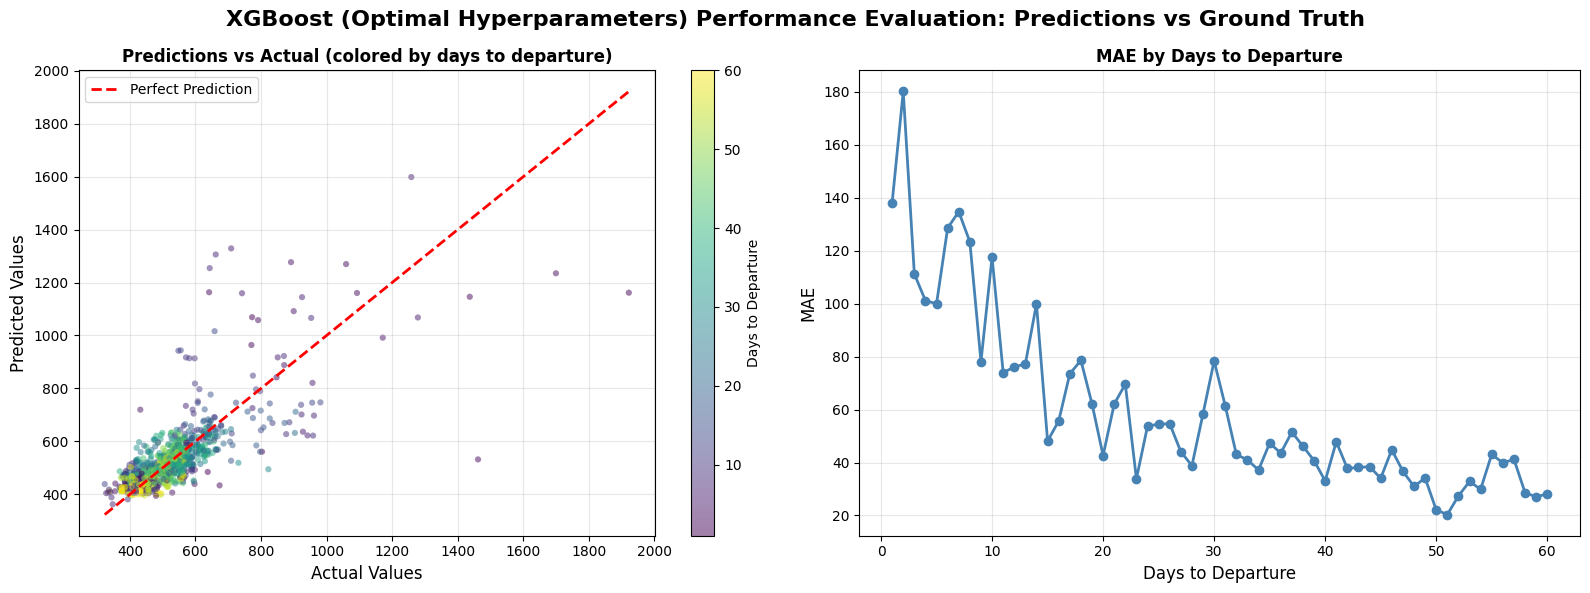

In [25]:
evaluate_and_visualize_predictions(
    y_val, y_val_pred, target_cols, model_name="XGBoost (Optimal Hyperparameters)"
)
print("")

## Comparison with Ridge Regression
A simpler linear regression model is trained to compare it with XGBoost's performance as reference.

Ridge - Mean MAE: 72.01, Min: 39.06, Max: 183.34
XGBoost (Baseline) - Mean MAE: 67.61, Min: 27.42, Max: 190.71
XGBoost (Optimal) - Mean MAE: 59.63, Min: 20.34, Max: 180.19


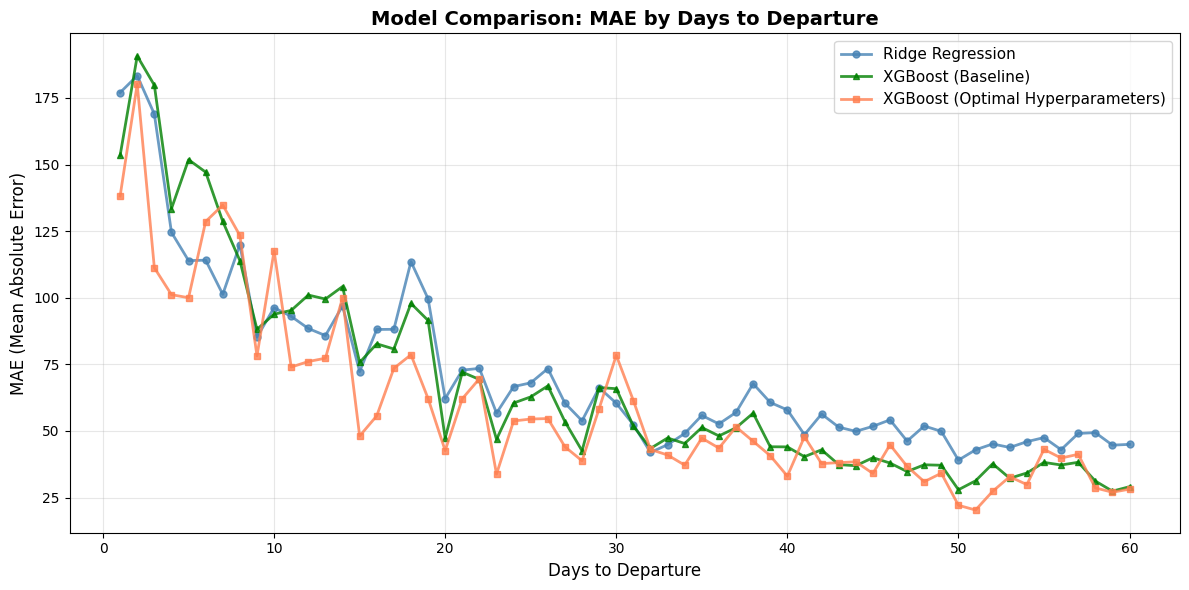

In [ ]:
from sklearn.linear_model import Ridge


ridge_base = Ridge(alpha=1.0, random_state=42)  
ridge_model = MultiOutputRegressor(ridge_base)
ridge_model.fit(X_train, y_train)

y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)

ridge_train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
ridge_val_mae = mean_absolute_error(y_val, y_val_pred_ridge)

xgb_baseline_base = XGBRegressor(
    max_depth=100,
    learning_rate=0.001,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)
xgb_baseline_model = MultiOutputRegressor(xgb_baseline_base)
xgb_baseline_model.fit(X_train, y_train)

y_val_pred_xgb_baseline = xgb_baseline_model.predict(X_val)
xgb_baseline_val_mae = mean_absolute_error(y_val, y_val_pred_xgb_baseline)

if 'model' not in globals() or model is None:
    print("\nTraining XGBoost model with optimal hyperparameters...")
    xgb_optimal_base = XGBRegressor(
        max_depth=3,
        learning_rate=0.03,
        n_estimators=100,
        subsample=0.7,
        colsample_bytree=1.0,
        reg_lambda=2.0,
        reg_alpha=0.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
    )
    model = MultiOutputRegressor(xgb_optimal_base)
    model.fit(X_train, y_train)
    print("XGBoost (Optimal) training completed!")

y_val_pred_xgb_optimal = model.predict(X_val)
xgb_optimal_val_mae = mean_absolute_error(y_val, y_val_pred_xgb_optimal)

n_samples, n_outputs = y_val.shape

ridge_mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred_ridge[:, i]) 
    for i in range(n_outputs)
]

xgb_baseline_mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred_xgb_baseline[:, i]) 
    for i in range(n_outputs)
]

xgb_optimal_mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred_xgb_optimal[:, i]) 
    for i in range(n_outputs)
]

days_list = [int(col.split()[0]) for col in target_cols]

print(f"Ridge - Mean MAE: {np.mean(ridge_mae_per_output):.2f}, "
      f"Min: {np.min(ridge_mae_per_output):.2f}, "
      f"Max: {np.max(ridge_mae_per_output):.2f}")
print(f"XGBoost (Baseline) - Mean MAE: {np.mean(xgb_baseline_mae_per_output):.2f}, "
      f"Min: {np.min(xgb_baseline_mae_per_output):.2f}, "
      f"Max: {np.max(xgb_baseline_mae_per_output):.2f}")
print(f"XGBoost (Optimal) - Mean MAE: {np.mean(xgb_optimal_mae_per_output):.2f}, "
      f"Min: {np.min(xgb_optimal_mae_per_output):.2f}, "
      f"Max: {np.max(xgb_optimal_mae_per_output):.2f}")

# Create comparison plot: MAE vs Days to Departure
plt.figure(figsize=(12, 6))
plt.plot(days_list, ridge_mae_per_output, marker='o', linewidth=2, markersize=5, 
         label='Ridge Regression', color='steelblue', alpha=0.8)
plt.plot(days_list, xgb_baseline_mae_per_output, marker='^', linewidth=2, markersize=5, 
         label='XGBoost (Baseline)', color='green', alpha=0.8)
plt.plot(days_list, xgb_optimal_mae_per_output, marker='s', linewidth=2, markersize=5, 
         label='XGBoost (Optimal Hyperparameters)', color='coral', alpha=0.8)

plt.xlabel('Days to Departure', fontsize=12)
plt.ylabel('MAE (Mean Absolute Error)', fontsize=12)
plt.title('Model Comparison: MAE by Days to Departure', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 61, 10))
plt.tight_layout()
plt.show()

## Running on the Test Set


In [30]:
y_test_pred_xgb_optimal = model.predict(X_test)
xgb_optimal_test_mae = mean_absolute_error(y_test, y_test_pred_xgb_optimal)

print(f"XGBoost Test MAE: {xgb_optimal_test_mae:.2f}")

XGBoost Test MAE: 52.33


Results: MAE of 52 dollars on the Test set!